
<div class="alert alert-block alert-warning">
<b>Important note: this notebook creates folders, do not re-run this notebook!</b>
    
to re-run:
- train_cropped_original/combined folder to move to bin
</div>

# 4.0 Model and Dataset Selection - Final Dataset

In seperate notebooks, the 5 datasets were trained and validated, as well as a sixth baseline model trained on the original dataset. 


***

### Installations Required

In [1]:
#!pip install pydot

#for mac: also install this
#!pip install pydot_ng

In [2]:
# pip install graphviz

#for mac:
#brew install graphviz in terminal

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import glob
import shutil

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.utils.vis_utils import plot_model


import sklearn
from sklearn.metrics import classification_report, confusion_matrix


plt.style.use('fast')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Defined Functions

In [4]:
def show_image(image, image_name, axis='off'):
    """ displays image from path"""
    image = plt.imread(image)
    plt.imshow(image, cmap="gray")
    plt.title(image_name)
    plt.axis(axis);

In [5]:
def convolution(image, kernel_):
    """applies filter onto image"""
    kernel = np.array(kernel_)
    result = np.zeros(image.shape)
    
    #output
    for ii in range(image.shape[0] - 3):
        for jj in range(image.shape[1] - 3):
            result[ii, jj] = (image[ii:ii+3, jj:jj+3] * kernel).sum()

    return result

In [6]:
def show_filtered(kernel_, subplot, kernel_name):
    """ showing on subplot for filtered: test_img_read"""
    filtered_img1 = convolution(test_img_read, kernel_)
    plt.subplot(subplot)
    plt.imshow(filtered_img1, cmap='bone')
    plt.title(f"Visualising {kernel_name}");

In [7]:
def show_conv(activations, subplots, conv_title):
    """ showing on subplot for conv layer filter"""

    plt.subplot(subplots)
    plt.imshow(activations, cmap='bone')
    plt.title(f"Visualising {conv_title}");

***

## Combine Train and Validation Set in AEE Dataset for Final Fit

In [8]:
#to combine training and validation set for refit

#create new combined folder in destination
#copy training folder over
shutil.copytree("../datasets/train_cropped_aee/train","../datasets/train_cropped_aee/combined_test")

#copy val files into folder
for files in glob.glob("../datasets/train_cropped_aee/val/angry/*"):
    shutil.copy(files,"../datasets/train_cropped_aee/combined_test/angry/")
    
for files in glob.glob("../datasets/train_cropped_aee/val/happy/*"):
    shutil.copy(files,"../datasets/train_cropped_aee/combined_test/happy/")

for files in glob.glob("../datasets/train_cropped_aee/val/neutral/*"):
    shutil.copy(files,"../datasets/train_cropped_aee/combined_test/neutral/")
    
for files in glob.glob("../datasets/train_cropped_aee/val/sad/*"):
    shutil.copy(files,"../datasets/train_cropped_aee/combined_test/sad/")


## Fit best model using combined dataset

In [9]:
#shaping X_train and X_test
train_data_dir = "../datasets/train_cropped_aee/combined_test"
validation_data_dir = "../datasets/train_cropped_aee/test"
filepath = "../models/best_model_aee_final_cp.hdf5"

img_rows, img_cols = 48, 48
num_classes = 4
epochs = 100
batch_size = 64

In [10]:
#callbacks
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_categorical_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_categorical_accuracy',
                          min_delta=0,
                          mode='auto',
                          patience=15,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy',
                              factor=0.2,
                              mode='auto',
                              patience=5,
                              verbose=1,
                              min_delta=0.001)

callbacks = [earlystop,checkpoint,reduce_lr]

In [11]:
#data augmentation for train dataset, normalize all 

val_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
        rescale=1./255,
      rotation_range=30,
      shear_range=0.3,
      zoom_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

Found 23799 images belonging to 4 classes.
Found 4205 images belonging to 4 classes.


In [12]:
global train_samples, validation_samples
train_samples = 23799
validation_samples = 4205


print(validation_generator.class_indices)

{'angry': 0, 'happy': 1, 'neutral': 2, 'sad': 3}


In [13]:
#Model
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation="relu", input_shape= (48,48,1)))
model.add(Conv2D(16, kernel_size=(3, 3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))
model.add(Conv2D(128, kernel_size=(3, 3), activation="relu"))

model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(4, activation="softmax"))


model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 18, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

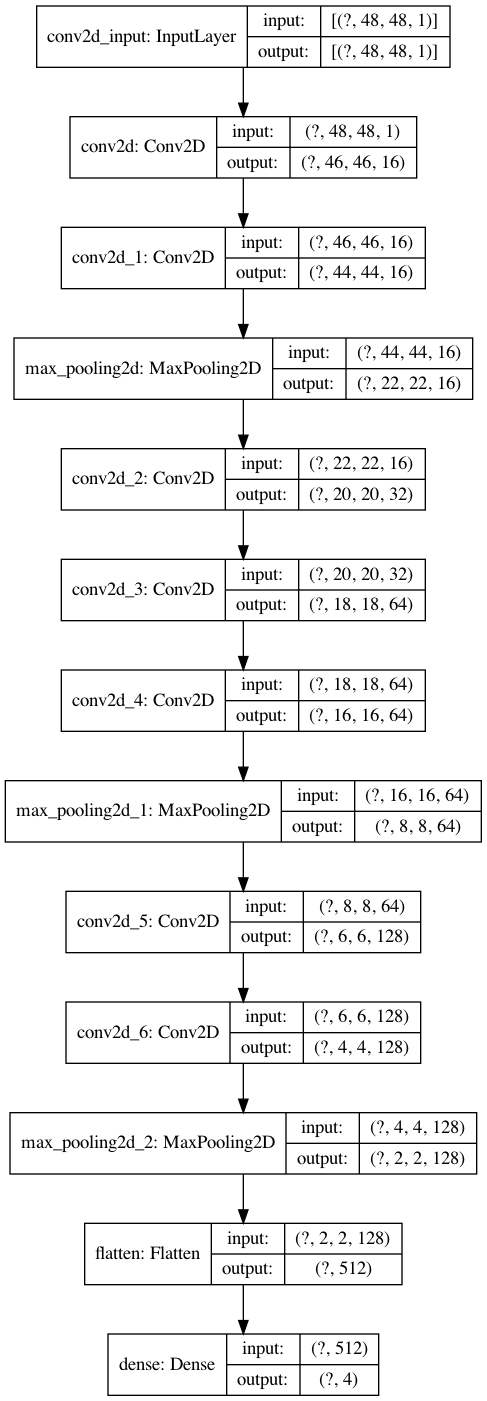

In [14]:
plot_model(model, to_file = "../images/model_plot_final.png", show_shapes=True, show_layer_names=True)

In [15]:
#compile model
model.compile(optimizer= Adam(lr=0.001, decay=1e-6),
              loss="categorical_crossentropy",
              metrics=["categorical_accuracy"])

In [16]:
%%time

#fit model
history = model.fit_generator(
            train_generator,
            steps_per_epoch=train_samples // batch_size,
            epochs=epochs,
            callbacks = callbacks,
            validation_data=validation_generator,
            validation_steps=validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
371/371 [==============================] - ETA: 0s - loss: 1.2633 - categorical_accuracy: 0.4148
Epoch 00001: val_categorical_accuracy improved from -inf to 0.54087, saving model to ../models/best_model_aee_final_cp.hdf5
371/371 [==============================] - 37s 99ms/step - loss: 1.2633 - categorical_accuracy: 0.4148 - val_loss: 1.1668 - val_categorical_accuracy: 0.5409 - lr: 0.0010
Epoch 2/100
371/371 [==============================] - ETA: 0s - loss: 1.0665 - categorical_accuracy: 0.5591
Epoch 00002: val_categorical_accuracy improved from 0.54087 to 0.61683, saving model to ../models/best_model_aee_final_cp.hdf5
371/371 [==============================] - 34s 92ms/step - loss: 1.0665 - categorical_accuracy: 0.5591 - val_loss: 0.9461 - val_categorical_accuracy: 0.6168 - lr: 0.0010
Epoch 3/100
371/371 [==============================] - ETA: 0s - loss: 0.9235 - categorical_accuracy: 0.6175
Epoch 

Epoch 22/100
371/371 [==============================] - ETA: 0s - loss: 0.6217 - categorical_accuracy: 0.7603
Epoch 00022: val_categorical_accuracy did not improve from 0.76731
371/371 [==============================] - 33s 90ms/step - loss: 0.6217 - categorical_accuracy: 0.7603 - val_loss: 0.6251 - val_categorical_accuracy: 0.7663 - lr: 0.0010
Epoch 23/100
371/371 [==============================] - ETA: 0s - loss: 0.6121 - categorical_accuracy: 0.7619
Epoch 00023: val_categorical_accuracy improved from 0.76731 to 0.76755, saving model to ../models/best_model_aee_final_cp.hdf5
371/371 [==============================] - 34s 93ms/step - loss: 0.6121 - categorical_accuracy: 0.7619 - val_loss: 0.6482 - val_categorical_accuracy: 0.7675 - lr: 0.0010
Epoch 24/100
371/371 [==============================] - ETA: 0s - loss: 0.6141 - categorical_accuracy: 0.7629
Epoch 00024: val_categorical_accuracy did not improve from 0.76755

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.000200000

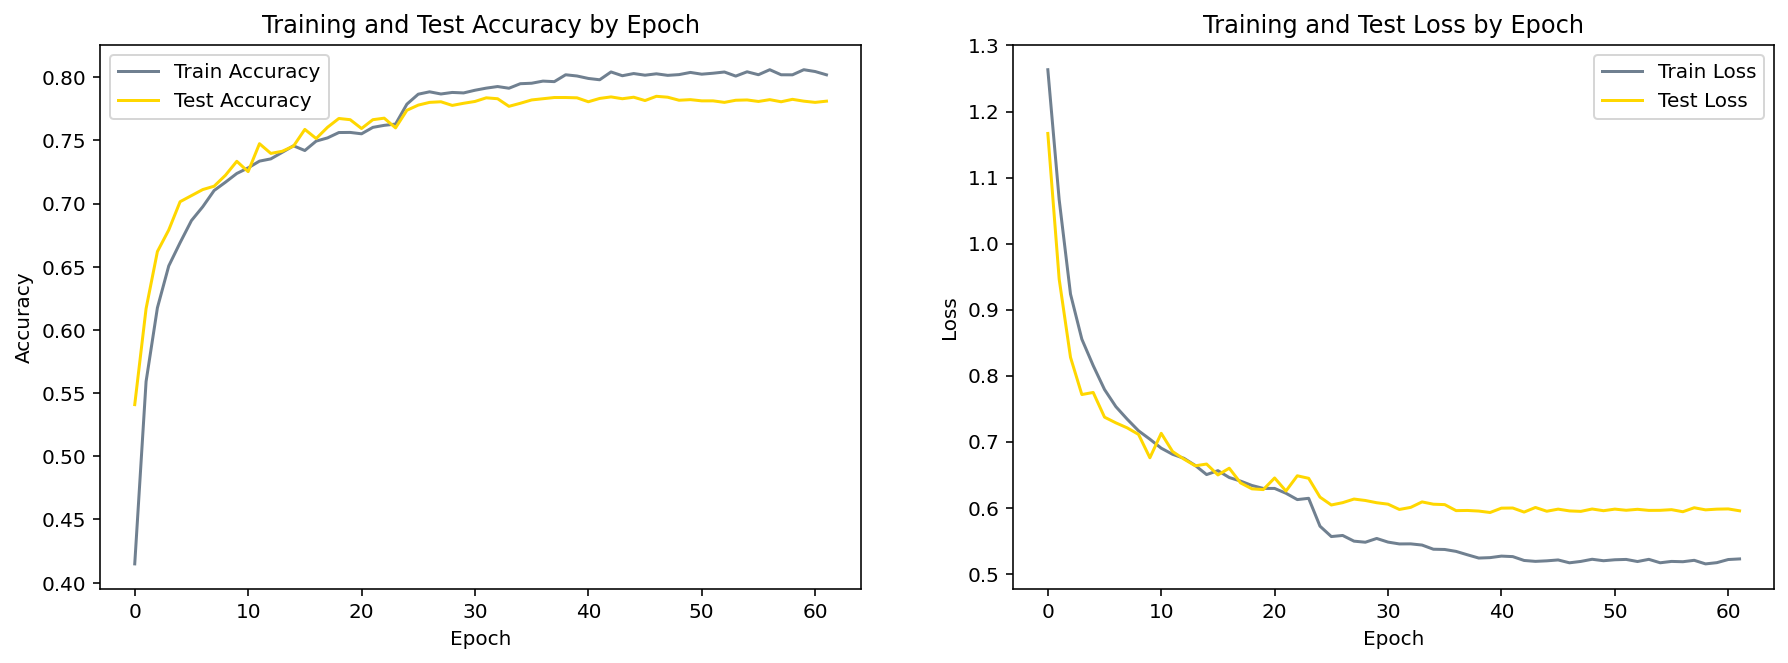

In [17]:
#plotting Accuracy and Loss curves
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history["categorical_accuracy"], label = 'Train Accuracy', color ='slategrey')
plt.plot(history.history["val_categorical_accuracy"], label = 'Test Accuracy', color ='gold')
plt.title("Training and Test Accuracy by Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

plt.subplot(122)
plt.plot(history.history["loss"], label = 'Train Loss', color ='slategrey')
plt.plot(history.history["val_loss"], label = 'Test Loss', color ='gold')
plt.title("Training and Test Loss by Epoch")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

Found 4205 images belonging to 4 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
Classification Report for Final Model
              precision    recall  f1-score   support

       angry       0.75      0.66      0.70       546
       happy       0.88      0.90      0.89      1667
     neutral       0.73      0.81      0.77      1402
         sad       0.64      0.51      0.57       590

    accuracy                           0.78      4205
   macro avg       0.75      0.72      0.73      4205
weighted avg       0.78      0.78      0.78      4205



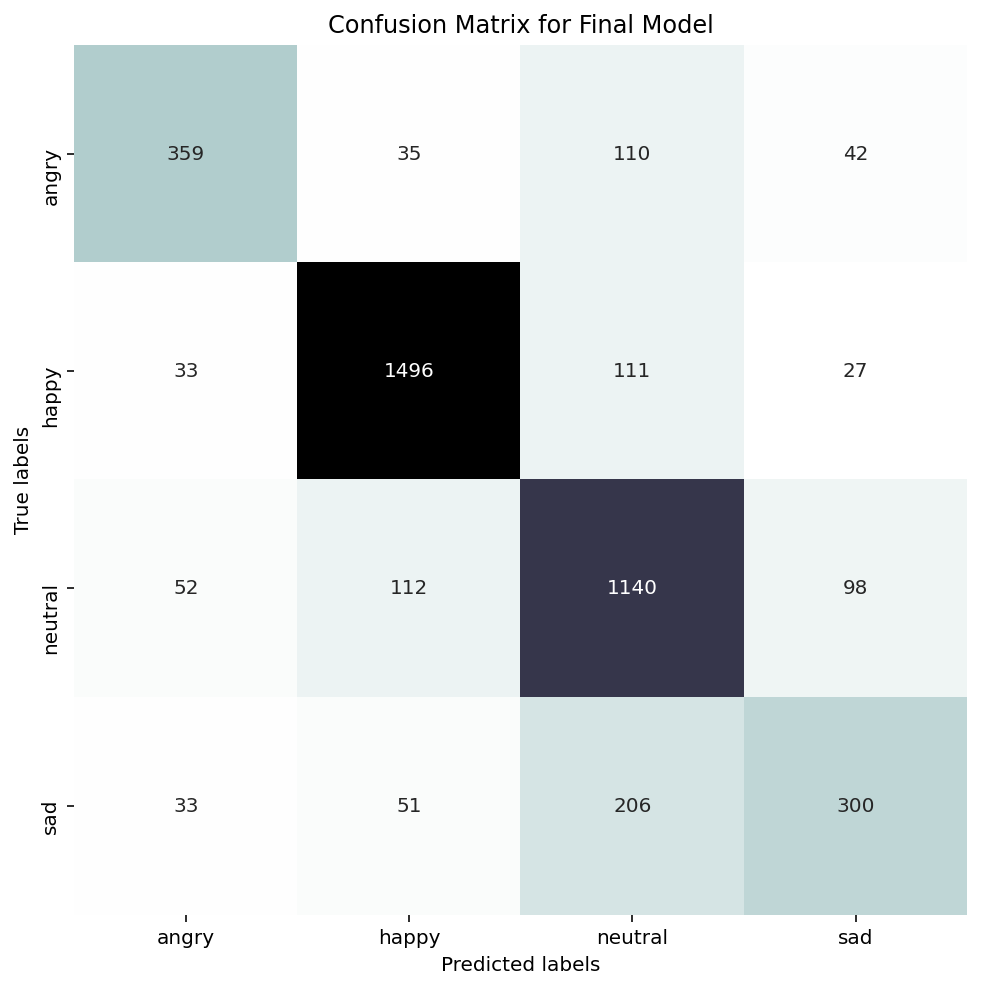

In [18]:
#Code credits: APEKSHA PRIYA, Priya Dwivedi
#confusion matrix and classification report

#validation generator with shuffle = false
validation_generator1 = val_datagen.flow_from_directory(
        validation_data_dir,
        color_mode = 'grayscale',
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

class_labels1 = validation_generator1.class_indices
class_labels1 = {v: k for k, v in class_labels1.items()}
classes1 = list(class_labels1.values())

#Confusion Matrix and Classification Report
Y_pred1 = model.predict_generator(validation_generator1, validation_samples // batch_size+1)
y_pred1 = np.argmax(Y_pred1, axis=1)
y_test1 = validation_generator1.classes

#Generate Confusion Matrix
cnf_matrix1 = confusion_matrix(y_test1, y_pred1)


print('Classification Report for Final Model')
target_names1 = list(class_labels1.values())
print(classification_report(y_test1, y_pred1, target_names=target_names1))


#plot confusion matrix
plt.figure(figsize=(8,8))
ax= plt.subplot()
sns.heatmap(cnf_matrix1, annot=True, ax = ax, cmap='bone_r', fmt='g', cbar=False)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix for Final Model'); 
ax.xaxis.set_ticklabels(['angry', 'happy', 'neutral', 'sad'])
ax.yaxis.set_ticklabels(['angry', 'happy', 'neutral', 'sad']);
                         

In [19]:
#save serialize model as json
model_json = model.to_json()
with open("../models/best_model_aee_final_model.json", "w") as json_file:
    json_file.write(model_json)
    
#save serialize model as HDF5
model.save_weights("../models/best_model_aee_final_model.h5")

print("Done (:")

Done (:


## Closer Look At Kernel Responses


In [20]:
#reveal layers
model.layers

weights: 2
kernel shape: (3, 3, 128, 128)
kernel shape: (3, 3)
kernel shape: (3, 3)


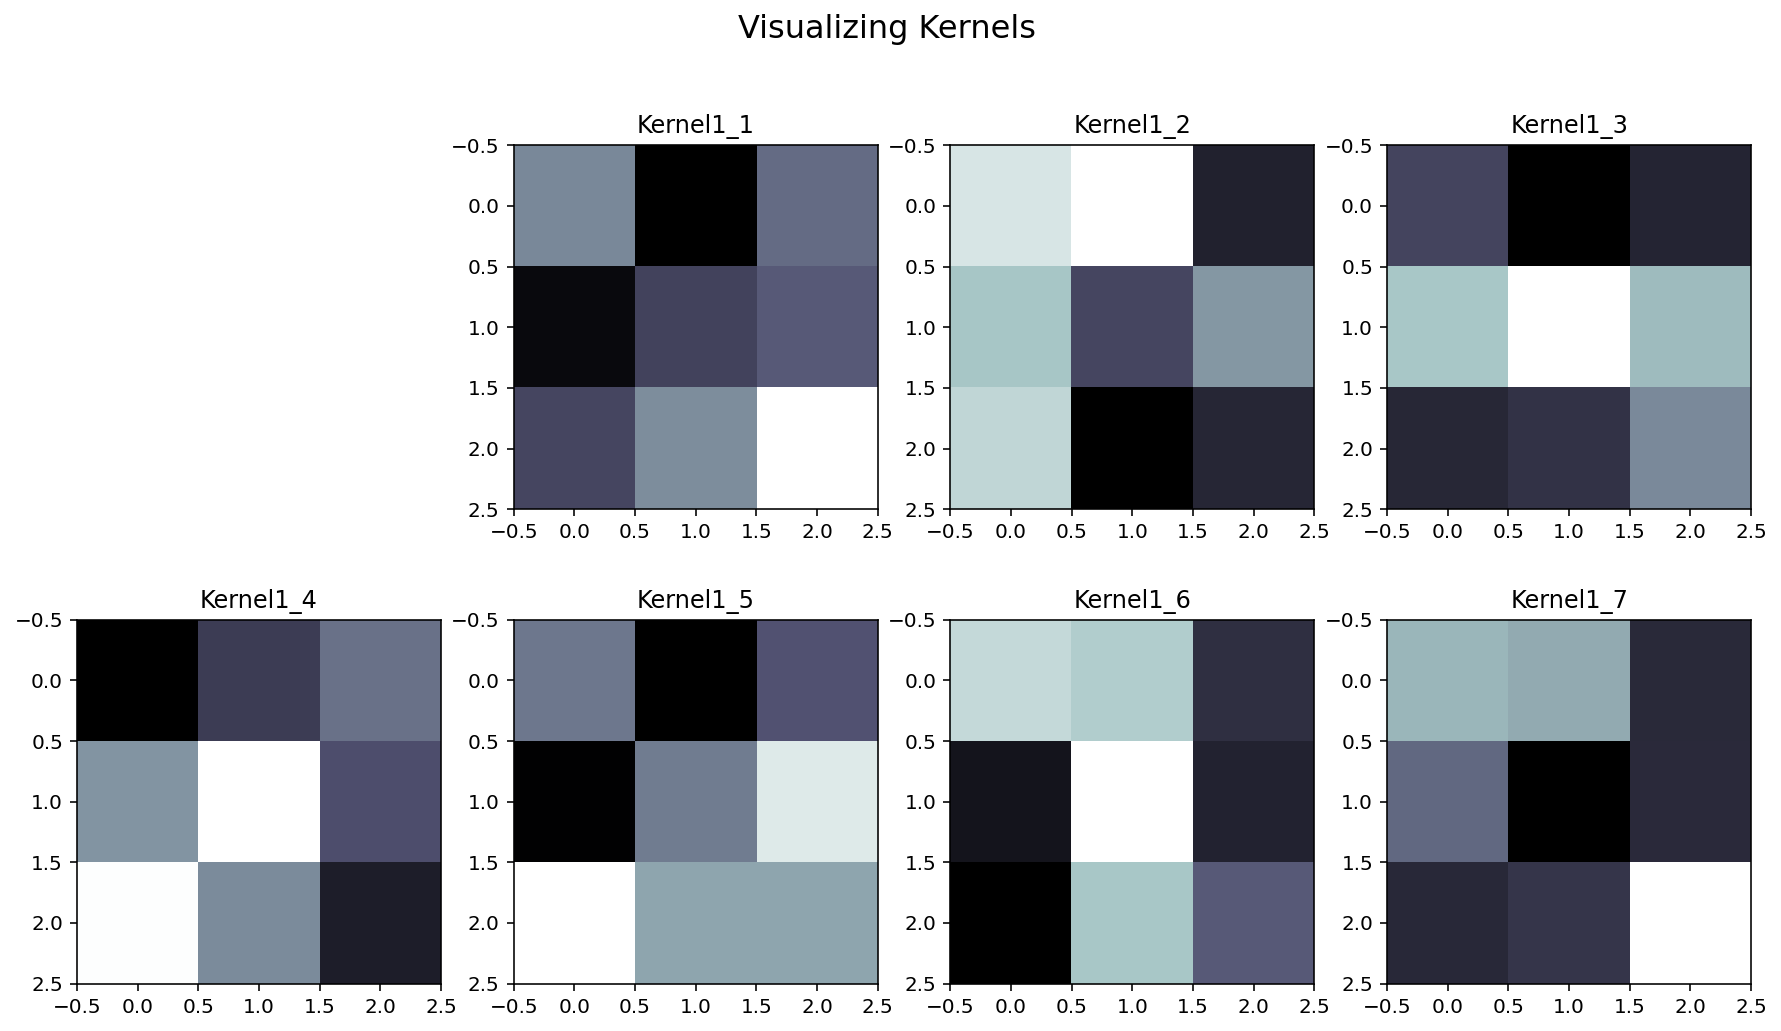

In [21]:
#getting model weights
conv1 = model.layers[0]
conv2 = model.layers[1]
conv3 = model.layers[3]
conv4 = model.layers[4]
conv5 = model.layers[5]
conv6 = model.layers[7]
conv7 = model.layers[8]

weights1 = conv1.get_weights()
weights2 = conv2.get_weights()
weights3 = conv3.get_weights()
weights4 = conv4.get_weights()
weights5 = conv5.get_weights()
weights6 = conv6.get_weights()
weights7 = conv7.get_weights()
print(f"weights: {len(weights7)}")


kernels1 = weights1[0]
kernels2 = weights2[0]
kernels3 = weights3[0]
kernels4 = weights4[0]
kernels5 = weights5[0]
kernels6 = weights6[0]
kernels7 = weights7[0]
print(f"kernel shape: {kernels7.shape}")

#visualising kernels by layers
kernel1_1 = kernels1[:,:,0,0]
kernel2_1 = kernels2[:,:,0,0]
kernel3_1 = kernels3[:,:,0,0]
kernel4_1 = kernels4[:,:,0,0]
kernel5_1 = kernels5[:,:,0,0]
kernel6_1 = kernels6[:,:,0,0]
kernel7_1 = kernels7[:,:,0,0]
print(f"kernel shape: {kernel1_1.shape}")

# kernels in layer 1
kernel1_1 = kernels1[:,:,0,0]
kernel1_2 = kernels1[:,:,0,1]
kernel1_3 = kernels1[:,:,0,2]
kernel1_4 = kernels1[:,:,0,9]
kernel1_5 = kernels1[:,:,0,10]
kernel1_6 = kernels1[:,:,0,14]
kernel1_7 = kernels1[:,:,0,15]
print(f"kernel shape: {kernel1_1.shape}")


#visualising kernels
plt.figure(figsize=(15,8))

plt.subplot(242)
plt.imshow(kernel1_1, cmap='bone_r')
plt.title("Kernel1_1");

plt.subplot(243)
plt.imshow(kernel1_2, cmap='bone_r')
plt.title("Kernel1_2");

plt.subplot(244)
plt.imshow(kernel1_3, cmap='bone_r')
plt.title("Kernel1_3");

plt.subplot(245)
plt.imshow(kernel1_4, cmap='bone_r')
plt.title("Kernel1_4");

plt.subplot(246)
plt.imshow(kernel1_5, cmap='bone_r')
plt.title("Kernel1_5");

plt.subplot(247)
plt.imshow(kernel1_6, cmap='bone_r')
plt.title("Kernel1_6");

plt.subplot(248)
plt.imshow(kernel1_7, cmap='bone_r')
plt.title("Kernel1_7")

plt.suptitle("Visualizing Kernels", fontsize=16);

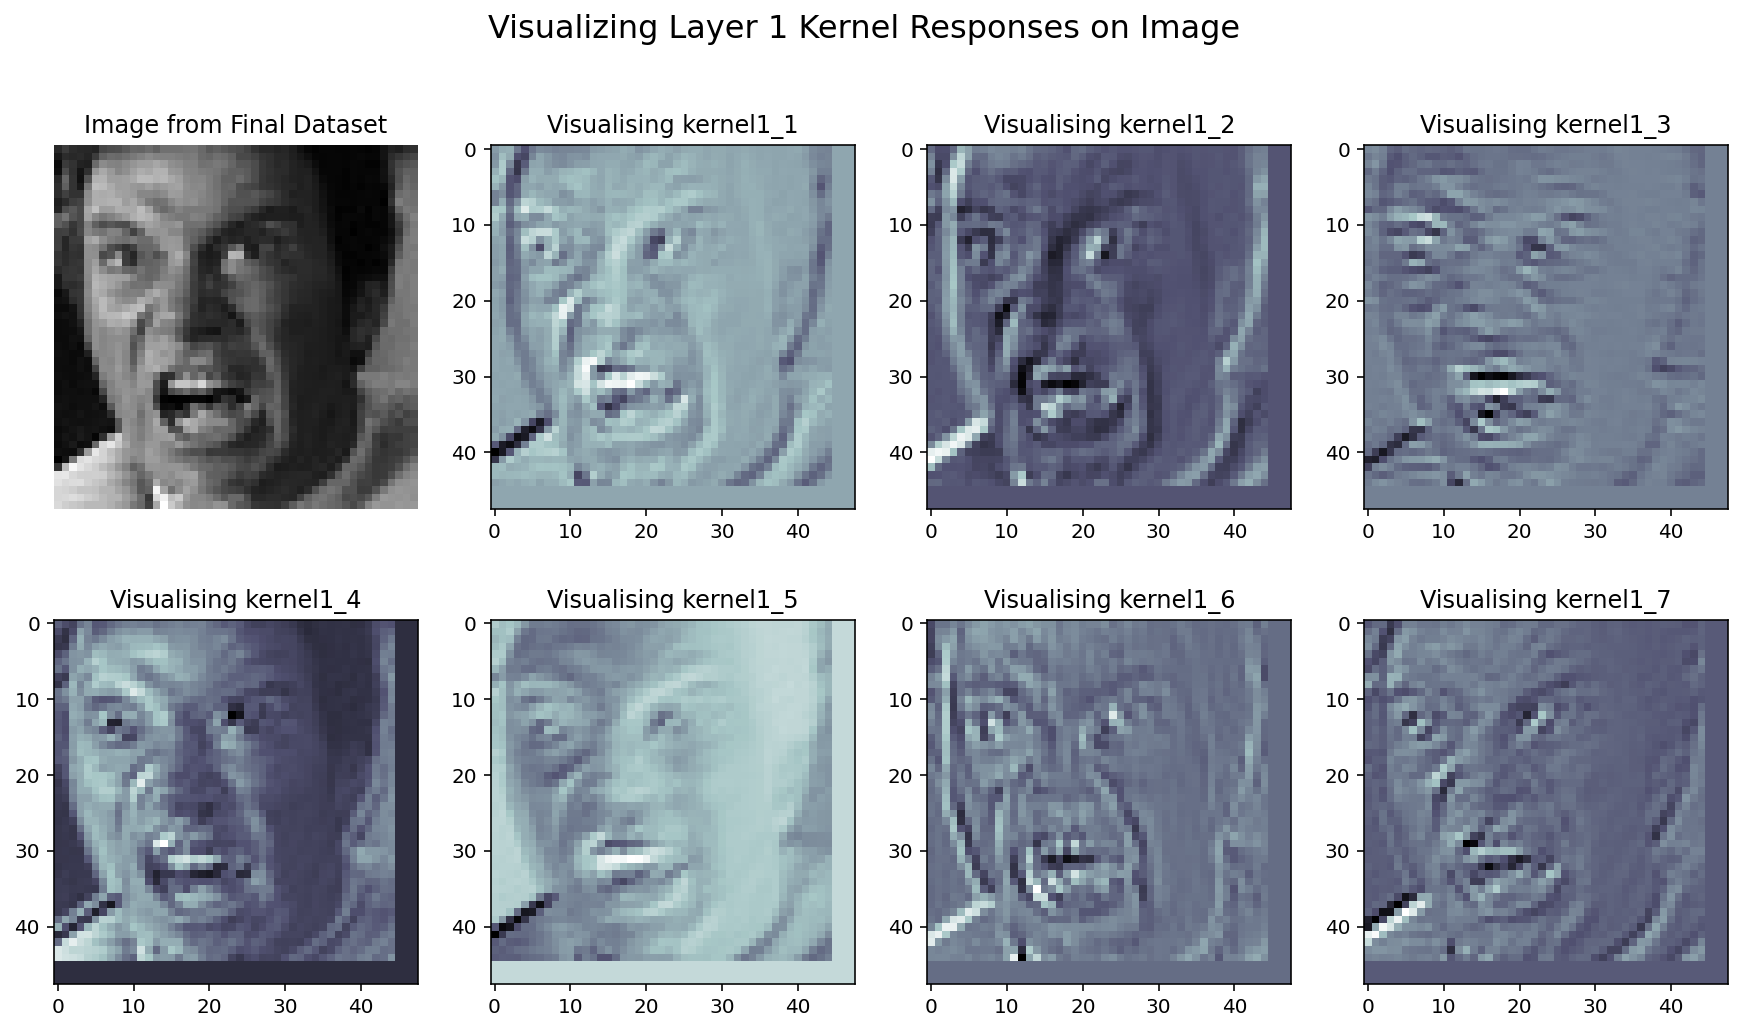

In [22]:
#visualising kernels reponses

#loading test image
test_data = glob.glob("../datasets/train_cropped_original/test/angry/*")
test_img = test_data[0]
test_img_read = plt.imread(test_img)

plt.figure(figsize=(15,8))

#original

plt.subplot(241)
plt.title("test")
show_image(test_img, "Image from Final Dataset")

#filtered images
show_filtered(kernel1_1, 242, "kernel1_1")
show_filtered(kernel1_2, 243, "kernel1_2")
show_filtered(kernel1_3, 244, "kernel1_3")
show_filtered(kernel1_4, 245, "kernel1_4")
show_filtered(kernel1_5, 246, "kernel1_5")
show_filtered(kernel1_6, 247, "kernel1_6")
show_filtered(kernel1_7, 248, "kernel1_7")
plt.suptitle("Visualizing Layer 1 Kernel Responses on Image", fontsize=16);

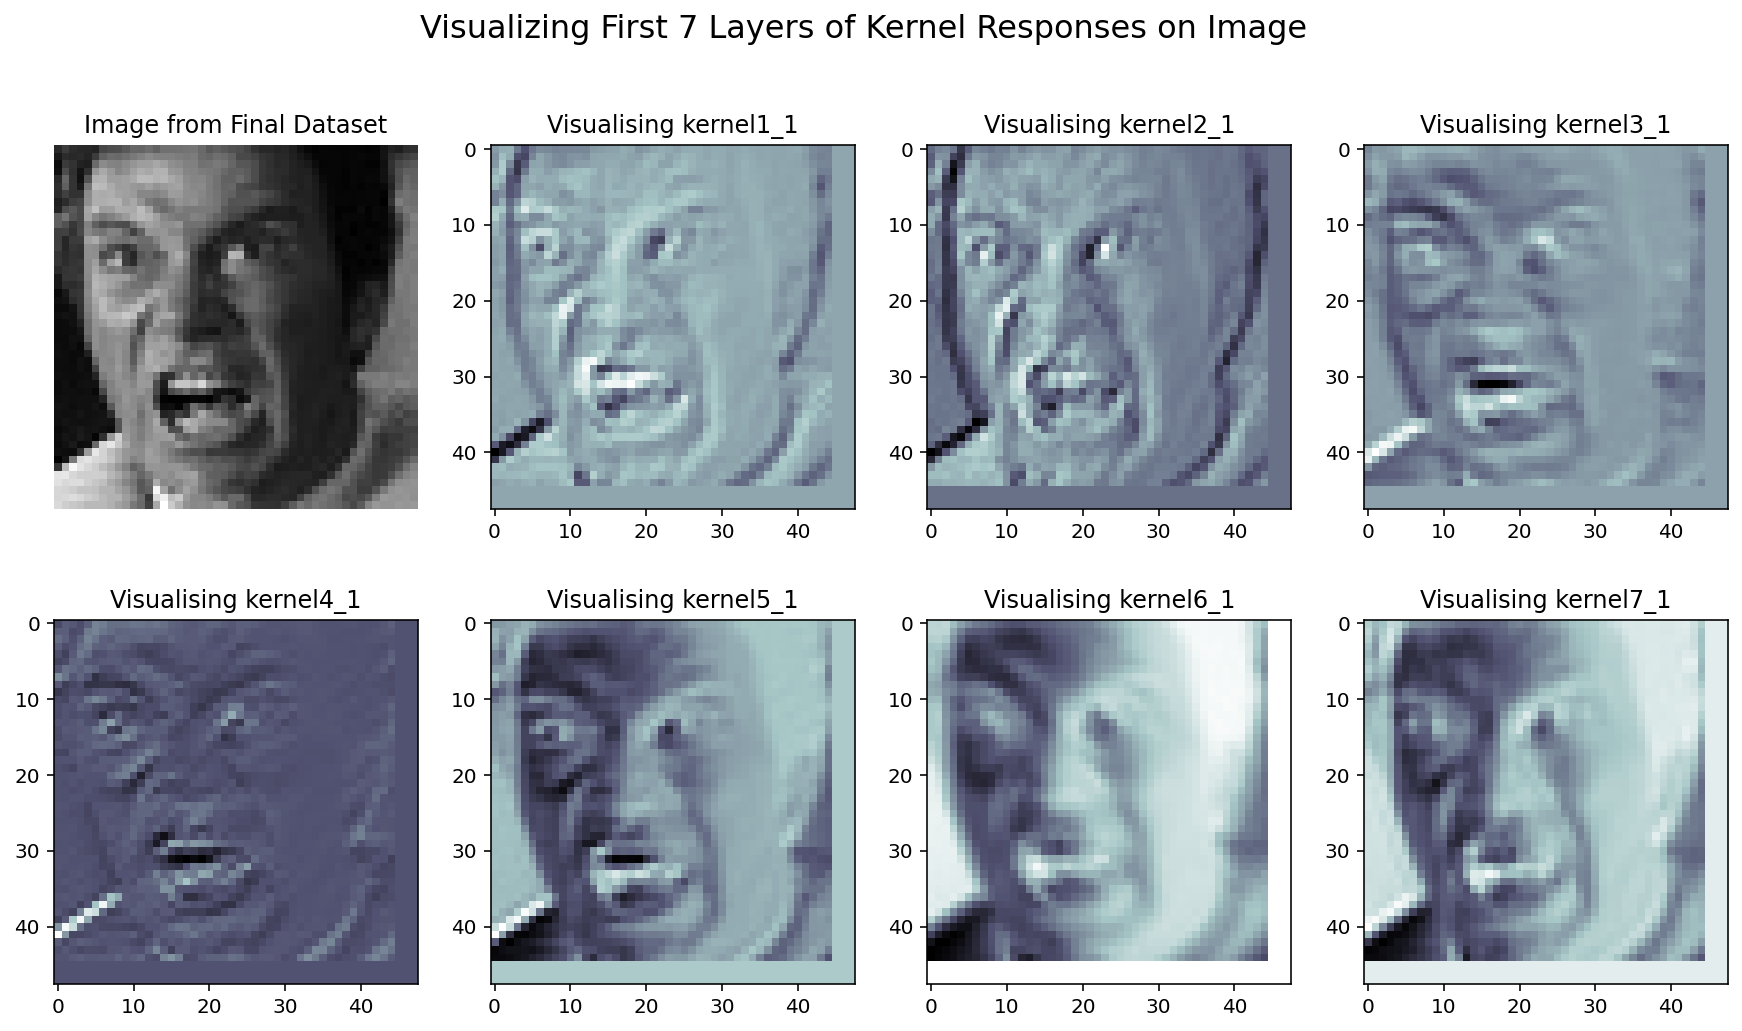

In [23]:
#visualising kernels reponses by level

#loading test image
test_data = glob.glob("../datasets/train_cropped_original/test/angry/*")
test_img = test_data[0]
test_img_read = plt.imread(test_img)

plt.figure(figsize=(15,8))

#original
plt.subplot(241)
show_image(test_img, "Image from Final Dataset")

#filtered images
show_filtered(kernel1_1, 242, "kernel1_1")
show_filtered(kernel2_1, 243, "kernel2_1")
show_filtered(kernel3_1, 244, "kernel3_1")
show_filtered(kernel4_1, 245, "kernel4_1")
show_filtered(kernel5_1, 246, "kernel5_1")
show_filtered(kernel6_1, 247, "kernel6_1")
show_filtered(kernel7_1, 248, "kernel7_1")
plt.suptitle("Visualizing First 7 Layers of Kernel Responses on Image", fontsize=16);

## Looking at Convolution Neuron Filter (Convolutional Mask) - Final Dataset

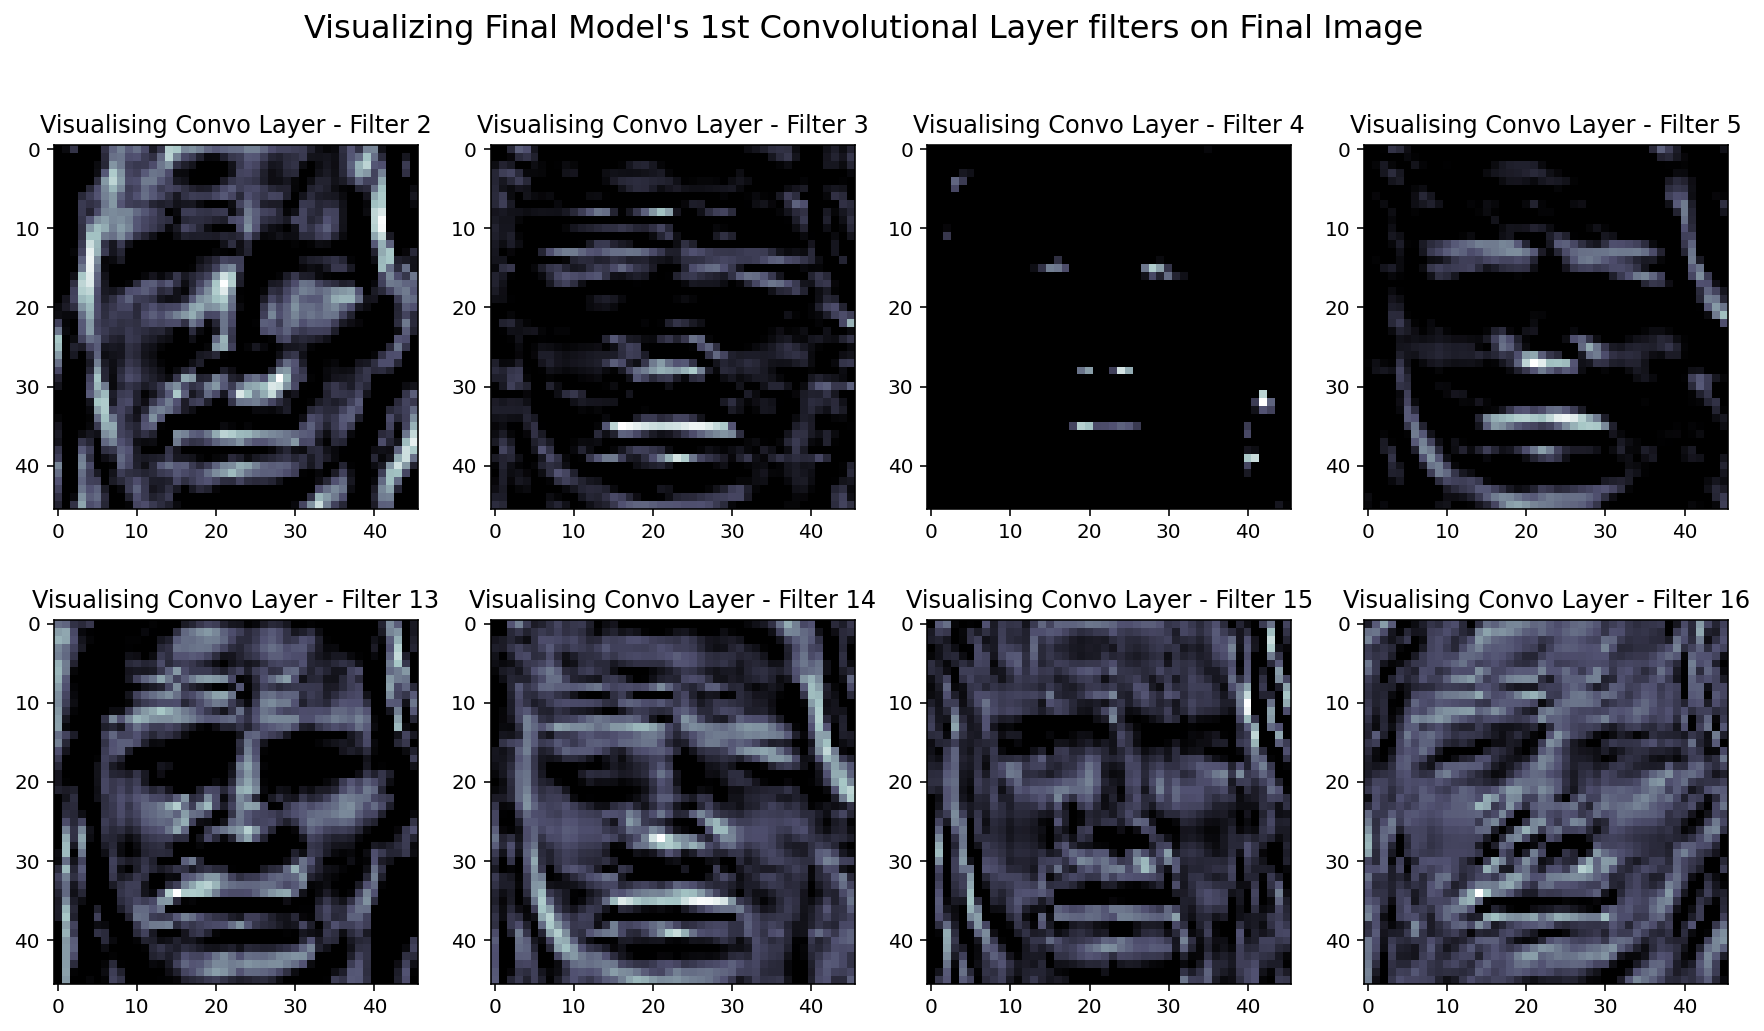

In [31]:
# looking at neuron filters in convolution layer

#sample image
sample = glob.glob("../datasets/train_cropped_ae/train/angry/*")
sample_img = Image.open(sample[1]).convert("L")
sample_img = img_to_array(sample_img)
sample_img = sample_img * 1./255
sample_img = np.expand_dims(sample_img, axis=0)
sample_img = np.vstack([sample_img])
sample_img.shape

#new model
layer_output = model.layers[0].output
layer_input = model.layers[0].input

layer_model =  Model(inputs= layer_input, outputs= layer_output)

# predict
activations = layer_model.predict(sample_img)

# plot activations
plt.figure(figsize=(15,8))
show_conv(activations[0,:,:,1], 241, "Convo Layer - Filter 2")
show_conv(activations[0,:,:,2], 242, "Convo Layer - Filter 3")
show_conv(activations[0,:,:,3], 243, "Convo Layer - Filter 4")
show_conv(activations[0,:,:,4], 244, "Convo Layer - Filter 5")
show_conv(activations[0,:,:,12], 245, "Convo Layer - Filter 13")
show_conv(activations[0,:,:,13], 246, "Convo Layer - Filter 14")
show_conv(activations[0,:,:,14], 247, "Convo Layer - Filter 15")
show_conv(activations[0,:,:,15], 248, "Convo Layer - Filter 16")
plt.suptitle("Visualizing Final Model's 1st Convolutional Layer filters on Final Image", fontsize=16);

## Looking at Convolution Neuron Filter (Convolutional Mask) - Original Dataset

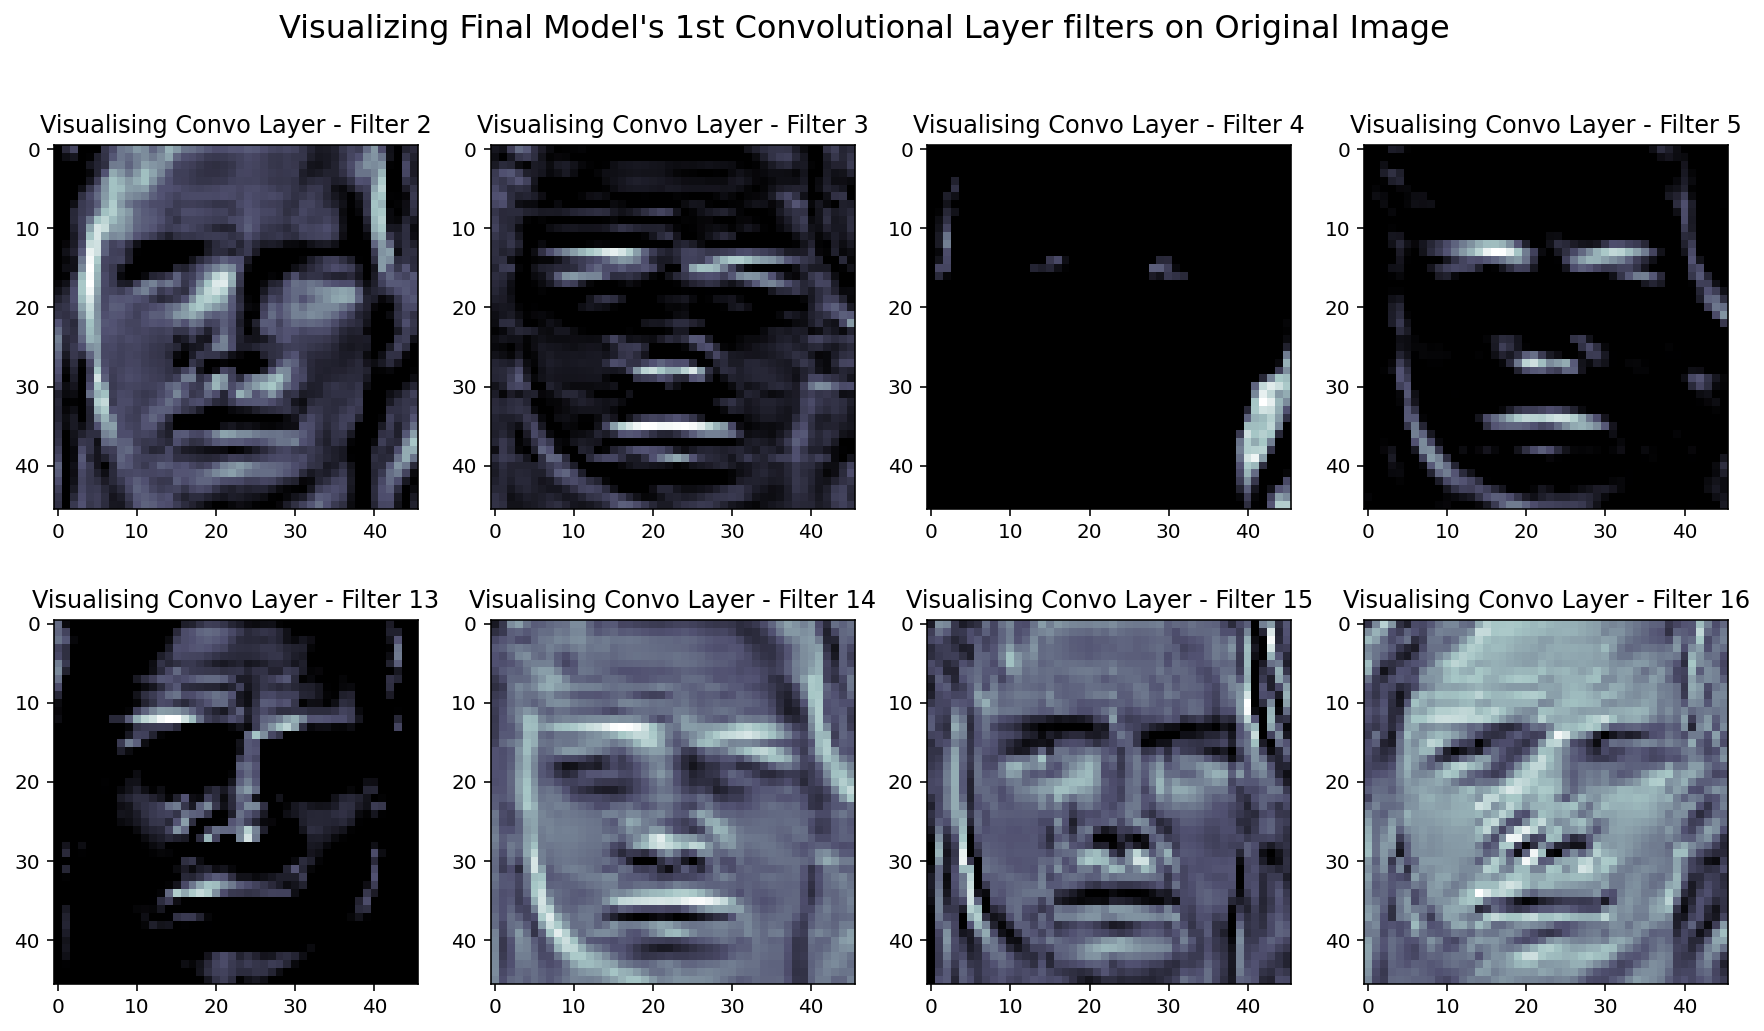

In [27]:
# looking at neuron filters in convolution layer

#sample image
sample = glob.glob("../datasets/train_cropped_original/train/angry/*")
sample_img = plt.imread(sample[1])
sample_img = img_to_array(sample_img)
sample_img = sample_img * 1./255
sample_img = np.expand_dims(sample_img, axis=0)
sample_img = np.vstack([sample_img])
sample_img.shape

#new model
layer_output = model.layers[0].output
layer_input = model.layers[0].input

layer_model =  Model(inputs= layer_input, outputs= layer_output)

# predict
activations = layer_model.predict(sample_img)

# plot activations
plt.figure(figsize=(15,8))

show_conv(activations[0,:,:,1], 241, "Convo Layer - Filter 2")
show_conv(activations[0,:,:,2], 242, "Convo Layer - Filter 3")
show_conv(activations[0,:,:,3], 243, "Convo Layer - Filter 4")
show_conv(activations[0,:,:,4], 244, "Convo Layer - Filter 5")
show_conv(activations[0,:,:,12], 245, "Convo Layer - Filter 13")
show_conv(activations[0,:,:,13], 246, "Convo Layer - Filter 14")
show_conv(activations[0,:,:,14], 247, "Convo Layer - Filter 15")
show_conv(activations[0,:,:,15], 248, "Convo Layer - Filter 16")
plt.suptitle("Visualizing Final Model's 1st Convolutional Layer filters on Original Image", fontsize=16);